In [1]:
import os
import numpy as np
import scipy.spatial.distance as dist
import matplotlib as mpl
import matplotlib.pyplot as plt
import gudhi

_tol = 1e-10

In [2]:
# Very important to compile IBloFunMatch.cc and obtain the correct executable path
EXECUTABLE_PATH = f"..\\x64\\Debug\\IBloFunMatchCPP.exe" # this is my particular path

In [3]:
def get_IBloFunMatch_output_range(data, y, S_list, yS_list, NUM_class, NUM_subset, attributes, types_list, output_dir):
    IBloFunMatch_output = [] # Store all output here 
    # Buffer files to write subsets and classes for communicating with C++ program 
    f_ind_sampl = output_dir + "\\indices_sample.out"
    f_dist_X = output_dir + "\\dist_X.out"
    f_dist_S = output_dir + "\\dist_S.out"
    for idx_class in range(NUM_class):
        for idx_subset in range(NUM_subset):
            output_data = {}
            # Subset and dataset points pertaining to class 
            subset = S_list[idx_subset]
            y_subset = yS_list[idx_subset]
            S = subset[y_subset==idx_class]
            X = data[y==idx_class]
            output_data["S"]=S
            output_data["X"]=X
            # Indices of points from S within X and save
            idS = [np.argmax(np.sum(abs(X - pt), axis=1) < _tol) for pt in S]
            output_data["idS"]=idS
            np.savetxt(f_ind_sampl, idS, fmt="%d", newline="\n")
            # Compute distance matrices and save
            Dist_X = dist.squareform(dist.pdist(X))
            Dist_S = dist.squareform(dist.pdist(S))
            np.savetxt(f_dist_X, Dist_X, fmt="%.14e", delimiter=" ", newline="\n")
            np.savetxt(f_dist_S, Dist_S, fmt="%.14e", delimiter=" ", newline="\n")
            # Call IBloFunMatch C++ program (only for dimension 1 PH)
            ! {EXECUTABLE_PATH + " " + f_dist_S + " " + f_dist_X + " " + f_ind_sampl + " -d 2"}
            # Save barcodes and representatives reading them from output files
            data_read = []
            for attribute_name, typename in zip(attributes, types_list):
                print(f"attribute:{attribute_name}, type:{typename}")
                print(output_dir + "\\" + attribute_name + ".out")
                with open(output_dir + "\\" + attribute_name + ".out") as file:
                    for line in file:
                        if(attribute_name == "induced_matching"):
                            data_read.append(int(line))
                        else:
                            data_line = line.split(" ")
                            if (typename=="int"): # lines end with additional space
                                data_line=data_line[:-1]
                            data_read.append(list(np.array(data_line).astype(typename)))
                        # end if else 
                    # end reading file lines 
                    if typename=="float":
                        output_data[attribute_name] = np.array(data_read)
                    else:
                        output_data[attribute_name] = data_read.copy()
                    # end if-else 
                # end opening file 
                data_read.clear()
            # end saving all attributes 
            # end for 
            IBloFunMatch_output.append(output_data)
        # subset range 
    # class range  
    return IBloFunMatch_output
# def get_IBloFunMatch_output_range

## Define a moving point cloud

In [4]:
def take_sample(point_cloud, no_samples, seed=None):
    """ From PerMaViss.py
    """
    if seed != None:
        np.random.seed(seed)
    no_points = len(point_cloud)
    no_samples = min(no_points, no_samples)
    Dist = dist.squareform(dist.pdist(point_cloud))
    k = int(np.random.rand() * no_points) - 1
    selection = [k]
    point_selection = [point_cloud[k]]
    for i in range(no_samples-1):
        not_selected = np.setdiff1d(range(no_points), selection)
        rest_Dist = np.min(Dist[not_selected][:, selection], axis=1)
        k = not_selected[np.argmax(rest_Dist)]
        selection.append(k)
        point_selection.append(point_cloud[k])

    return np.array(point_selection)

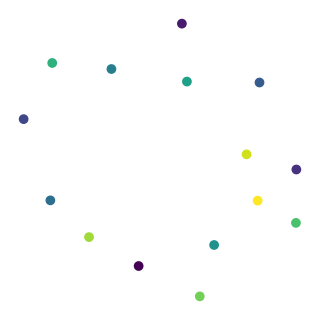

In [5]:
point_cloud = []
RandGen = np.random.default_rng(5)
num_samples, low_rad, big_rad = 40, 4, 7
radii = RandGen.uniform(low_rad, big_rad, num_samples)
angles = RandGen.uniform(0,2*np.pi, num_samples)
C1 = np.array([np.cos(angles)*radii, np.sin(angles)*radii]).T
num_samples = 15
C1 = take_sample(C1, num_samples, seed=4)
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes((0,0,1,1))
viridis_cm = mpl.colormaps["viridis"].resampled(num_samples)
colorlist = [viridis_cm(idx/num_samples) for idx in range(num_samples)]
ax.scatter(C1[:,0], C1[:,1], color=colorlist)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("points_fleet.png")

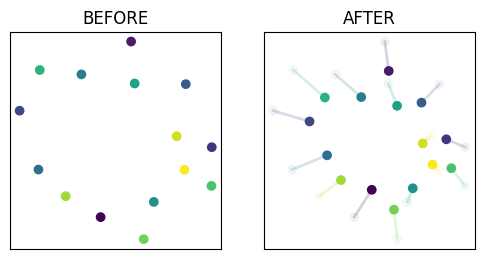

In [6]:
Csmall = C1*0.7 + (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*0.9 + [0.7,0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].scatter(C1[:,0], C1[:,1], color=colorlist, zorder=2)
ax[1].scatter(C1[:,0], C1[:,1], color=colorlist, alpha=0.05, zorder=1.5)
ax[1].scatter(Csmall[:,0], Csmall[:,1], color=colorlist, zorder=2)
# Draw trajectory lines
for ptA, ptB, color in zip(C1, Csmall, colorlist):
    new_line = mpl.lines.Line2D([ptA[0], ptB[0]], [ptA[1], ptB[1]], lw=2, color=color, zorder=1, alpha=0.2)
    ax[1].add_line(new_line)
# Set axis parameters
for ax_it in ax:
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.set_aspect("equal")
# end for 
ax[0].set_title("BEFORE")
ax[1].set_title("AFTER")
plt.savefig("points_fleet.png")

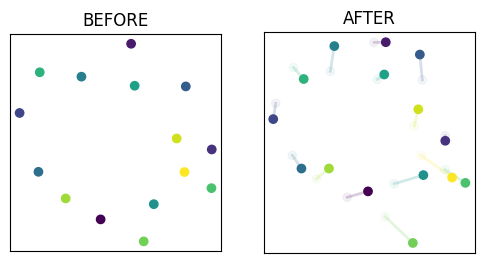

In [13]:
RandGen = np.random.default_rng(5)
C2 = C1*1.1 + (RandGen.random(num_samples*2).reshape((num_samples, 2)) -[0.5, 0.5])*3 + [0.7,0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax[0].scatter(C1[:,0], C1[:,1], color=colorlist, zorder=2)
ax[1].scatter(C1[:,0], C1[:,1], color=colorlist, alpha=0.05, zorder=1.5)
ax[1].scatter(C2[:,0], C2[:,1], color=colorlist, zorder=2)
# Draw trajectory lines
for ptA, ptB, color in zip(C1, C2, colorlist):
    new_line = mpl.lines.Line2D([ptA[0], ptB[0]], [ptA[1], ptB[1]], lw=2, color=color, zorder=1, alpha=0.2)
    ax[1].add_line(new_line)
# Set axis parameters
for ax_it in ax:
    ax_it.set_xticks([])
    ax_it.set_yticks([])
    ax_it.set_aspect("equal")
# end for 
ax[0].set_title("BEFORE")
ax[1].set_title("AFTER")
plt.savefig("points_fleet_2.png")

### Depict middle distance $d_M$ compared to $d_1$ and $d_2$

In [14]:
import gudhi
import scipy.spatial.distance as dist

In [15]:
def plot_complex(Dist_X, points, max_rad, ax):
    rips_complex = gudhi.RipsComplex(distance_matrix=Dist_X, max_edge_length=max_rad)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    for filtered_value in simplex_tree.get_filtration():
        spx = filtered_value[0]
        if len(spx)==2:
            edge = points[spx]
            ax.add_line(mpl.lines.Line2D(edge[:,0], edge[:,1], lw=3, color="black", zorder=1))
        elif len(spx)==3:
            triangle = points[spx] 
            ax.add_patch(mpl.patches.Polygon(triangle, facecolor="black", alpha=0.3, zorder=0.5))
        # end if else 
    # end for 
# def plot_complex

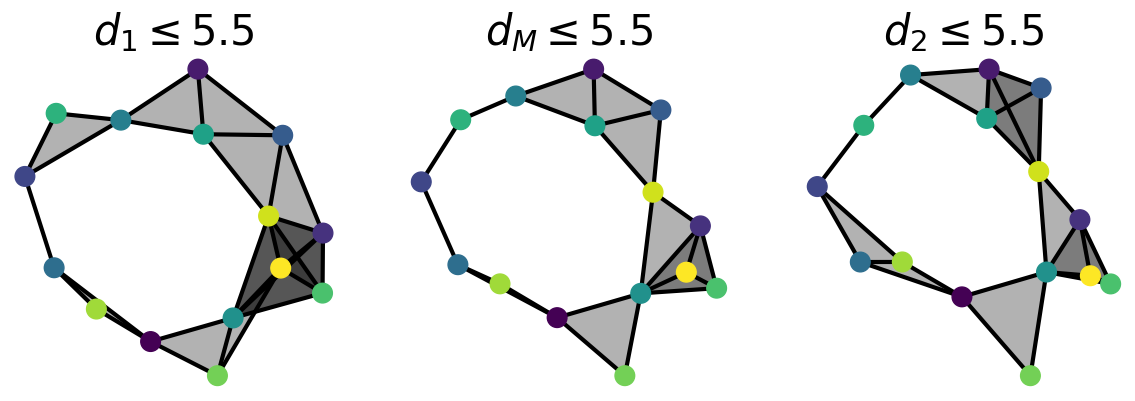

In [20]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
max_rad =5.5
point_list = [C1, (C1+C2)/2, C2]
# Compute Distance Matrices
Dist_C1 = dist.squareform(dist.pdist(C1))
Dist_C2 = dist.squareform(dist.pdist(C2))
Dist_M = np.maximum(Dist_C1, Dist_C2)
Dist_list = [Dist_C1, Dist_M, Dist_C2]
title_list = [f"$d_1 \leq {max_rad:.1f}$", f"$d_M \leq {max_rad:.1f}$", f"$d_2 \leq {max_rad:.1f}$"]
for idx, (X, Dist_X) in enumerate(zip(point_list, Dist_list)):
    ax[idx].scatter(X[:,0], X[:,1], zorder=2, color=colorlist, s=200)
    plot_complex(Dist_X, X, max_rad, ax[idx])
    ax[idx].set_aspect("equal")
    ax[idx].set_frame_on(False)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_title(title_list[idx], fontsize=30)
# end for 
fig.tight_layout()
plt.savefig("VR_cpx_Middle.png")

In [ ]:
(Ver teorema de Dowkes)
